<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[22:11:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


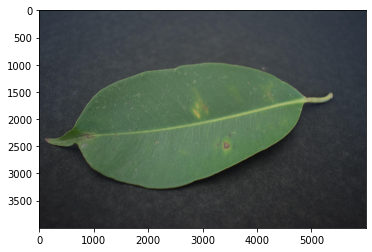

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

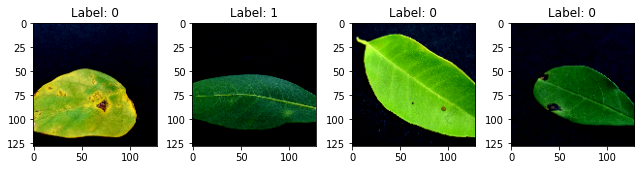

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[22:11:15] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[22:11:17] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2481274795120247 samples/sec                   batch loss = 0.9980937242507935 | accuracy = 0.4


Epoch[1] Batch[10] Speed: 1.2584406398259793 samples/sec                   batch loss = 0.5415709018707275 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2608925790020535 samples/sec                   batch loss = 0.7770305275917053 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2607988659043405 samples/sec                   batch loss = 0.9127958416938782 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2557260655795375 samples/sec                   batch loss = 0.5936743021011353 | accuracy = 0.53


Epoch[1] Batch[30] Speed: 1.2540989041258703 samples/sec                   batch loss = 0.5666923522949219 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2572045352599481 samples/sec                   batch loss = 0.5836085677146912 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2574160698507857 samples/sec                   batch loss = 0.7610175609588623 | accuracy = 0.5625


Epoch[1] Batch[45] Speed: 1.256154324474778 samples/sec                   batch loss = 0.5964943170547485 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.2529167821400906 samples/sec                   batch loss = 1.6029859781265259 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.2588697135768743 samples/sec                   batch loss = 1.1863170862197876 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.2647493262471494 samples/sec                   batch loss = 0.3749690353870392 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2661465950513526 samples/sec                   batch loss = 0.4557013511657715 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2639743763891993 samples/sec                   batch loss = 0.5586742162704468 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.2631199179784438 samples/sec                   batch loss = 0.5630608797073364 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.2583302082364554 samples/sec                   batch loss = 0.9781399369239807 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2592877373509528 samples/sec                   batch loss = 0.5903909206390381 | accuracy = 0.6088235294117647


Epoch[1] Batch[90] Speed: 1.2543803869082266 samples/sec                   batch loss = 0.5594497919082642 | accuracy = 0.6138888888888889


Epoch[1] Batch[95] Speed: 1.2586989555266428 samples/sec                   batch loss = 0.6005108952522278 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2677860299138337 samples/sec                   batch loss = 0.5249634385108948 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.259141246255347 samples/sec                   batch loss = 0.3629169166088104 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.2669735798969972 samples/sec                   batch loss = 1.2821636199951172 | accuracy = 0.6295454545454545


Epoch[1] Batch[115] Speed: 1.2618657818401522 samples/sec                   batch loss = 0.9757080078125 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.2609139956795632 samples/sec                   batch loss = 0.394676148891449 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.2587729953639755 samples/sec                   batch loss = 0.38131648302078247 | accuracy = 0.636


Epoch[1] Batch[130] Speed: 1.257469977794252 samples/sec                   batch loss = 0.9770914316177368 | accuracy = 0.6384615384615384


Epoch[1] Batch[135] Speed: 1.2517333377501934 samples/sec                   batch loss = 0.32509082555770874 | accuracy = 0.6370370370370371


Epoch[1] Batch[140] Speed: 1.2616768467343693 samples/sec                   batch loss = 0.7430360317230225 | accuracy = 0.6392857142857142


Epoch[1] Batch[145] Speed: 1.2632585854095475 samples/sec                   batch loss = 0.43602222204208374 | accuracy = 0.6431034482758621


Epoch[1] Batch[150] Speed: 1.2650703323901793 samples/sec                   batch loss = 0.5525891184806824 | accuracy = 0.6433333333333333


Epoch[1] Batch[155] Speed: 1.2626939296264734 samples/sec                   batch loss = 0.32804033160209656 | accuracy = 0.6403225806451613


Epoch[1] Batch[160] Speed: 1.2639008660061601 samples/sec                   batch loss = 0.5195350646972656 | accuracy = 0.640625


Epoch[1] Batch[165] Speed: 1.2640741813704974 samples/sec                   batch loss = 1.185660719871521 | accuracy = 0.6318181818181818


Epoch[1] Batch[170] Speed: 1.2670183591066084 samples/sec                   batch loss = 0.6113563776016235 | accuracy = 0.6323529411764706


Epoch[1] Batch[175] Speed: 1.257503154210835 samples/sec                   batch loss = 1.393007755279541 | accuracy = 0.6328571428571429


Epoch[1] Batch[180] Speed: 1.255784434506449 samples/sec                   batch loss = 0.436320424079895 | accuracy = 0.6305555555555555


Epoch[1] Batch[185] Speed: 1.2609667823671658 samples/sec                   batch loss = 0.44732093811035156 | accuracy = 0.6324324324324324


Epoch[1] Batch[190] Speed: 1.2625942474547505 samples/sec                   batch loss = 0.4981669783592224 | accuracy = 0.631578947368421


Epoch[1] Batch[195] Speed: 1.2687336390898933 samples/sec                   batch loss = 0.4875964820384979 | accuracy = 0.6358974358974359


Epoch[1] Batch[200] Speed: 1.2647158617238676 samples/sec                   batch loss = 0.4923960268497467 | accuracy = 0.63625


Epoch[1] Batch[205] Speed: 1.2633793022172672 samples/sec                   batch loss = 0.5737632513046265 | accuracy = 0.6402439024390244


Epoch[1] Batch[210] Speed: 1.2632137862231885 samples/sec                   batch loss = 0.410652220249176 | accuracy = 0.6452380952380953


Epoch[1] Batch[215] Speed: 1.2663322833661468 samples/sec                   batch loss = 0.621318519115448 | accuracy = 0.6476744186046511


Epoch[1] Batch[220] Speed: 1.2667039190757476 samples/sec                   batch loss = 0.3202781677246094 | accuracy = 0.6522727272727272


Epoch[1] Batch[225] Speed: 1.2673099797884149 samples/sec                   batch loss = 0.5447182655334473 | accuracy = 0.6522222222222223


Epoch[1] Batch[230] Speed: 1.2632984412843355 samples/sec                   batch loss = 0.23849456012248993 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.2698871747361027 samples/sec                   batch loss = 0.4567418396472931 | accuracy = 0.6574468085106383


Epoch[1] Batch[240] Speed: 1.2636862874592067 samples/sec                   batch loss = 0.4463179409503937 | accuracy = 0.6572916666666667


Epoch[1] Batch[245] Speed: 1.265990001697825 samples/sec                   batch loss = 0.5141411423683167 | accuracy = 0.6581632653061225


Epoch[1] Batch[250] Speed: 1.2629617905717583 samples/sec                   batch loss = 0.7168874144554138 | accuracy = 0.657


Epoch[1] Batch[255] Speed: 1.2710084337600402 samples/sec                   batch loss = 0.37818217277526855 | accuracy = 0.6568627450980392


Epoch[1] Batch[260] Speed: 1.2650468665289814 samples/sec                   batch loss = 0.6183491349220276 | accuracy = 0.6567307692307692


Epoch[1] Batch[265] Speed: 1.2747362860101525 samples/sec                   batch loss = 0.5623955726623535 | accuracy = 0.6584905660377358


Epoch[1] Batch[270] Speed: 1.2728298443309007 samples/sec                   batch loss = 0.9935117363929749 | accuracy = 0.6592592592592592


Epoch[1] Batch[275] Speed: 1.270057713186704 samples/sec                   batch loss = 0.7955548167228699 | accuracy = 0.6581818181818182


Epoch[1] Batch[280] Speed: 1.2684964121981859 samples/sec                   batch loss = 0.6290801167488098 | accuracy = 0.6571428571428571


Epoch[1] Batch[285] Speed: 1.2700664624482814 samples/sec                   batch loss = 0.2227087914943695 | accuracy = 0.6587719298245615


Epoch[1] Batch[290] Speed: 1.2663530249687303 samples/sec                   batch loss = 2.820847511291504 | accuracy = 0.6577586206896552


Epoch[1] Batch[295] Speed: 1.2732824133176173 samples/sec                   batch loss = 0.5250483155250549 | accuracy = 0.6610169491525424


Epoch[1] Batch[300] Speed: 1.2683223615575587 samples/sec                   batch loss = 0.29769062995910645 | accuracy = 0.6608333333333334


Epoch[1] Batch[305] Speed: 1.267243068397312 samples/sec                   batch loss = 0.6109450459480286 | accuracy = 0.6573770491803279


Epoch[1] Batch[310] Speed: 1.2634820581004484 samples/sec                   batch loss = 0.2839144468307495 | accuracy = 0.6596774193548387


Epoch[1] Batch[315] Speed: 1.2684543096195335 samples/sec                   batch loss = 0.540228009223938 | accuracy = 0.6587301587301587


Epoch[1] Batch[320] Speed: 1.2695674664982508 samples/sec                   batch loss = 0.39070606231689453 | accuracy = 0.66171875


Epoch[1] Batch[325] Speed: 1.2699730150294228 samples/sec                   batch loss = 0.33144891262054443 | accuracy = 0.6638461538461539


Epoch[1] Batch[330] Speed: 1.2675171723058505 samples/sec                   batch loss = 0.2954045534133911 | accuracy = 0.6651515151515152


Epoch[1] Batch[335] Speed: 1.2676979945059823 samples/sec                   batch loss = 0.6352173686027527 | accuracy = 0.6656716417910448


Epoch[1] Batch[340] Speed: 1.266008821425631 samples/sec                   batch loss = 0.34722426533699036 | accuracy = 0.6669117647058823


Epoch[1] Batch[345] Speed: 1.2707532227044176 samples/sec                   batch loss = 0.41512858867645264 | accuracy = 0.6659420289855073


Epoch[1] Batch[350] Speed: 1.2661345553835988 samples/sec                   batch loss = 0.6375433206558228 | accuracy = 0.6685714285714286


Epoch[1] Batch[355] Speed: 1.2721302276982944 samples/sec                   batch loss = 0.5878292322158813 | accuracy = 0.6711267605633803


Epoch[1] Batch[360] Speed: 1.2674646018020022 samples/sec                   batch loss = 0.912496030330658 | accuracy = 0.6736111111111112


Epoch[1] Batch[365] Speed: 1.2646272989244363 samples/sec                   batch loss = 0.3995397090911865 | accuracy = 0.6753424657534246


Epoch[1] Batch[370] Speed: 1.2580060100375245 samples/sec                   batch loss = 0.2109140157699585 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2636906658849265 samples/sec                   batch loss = 0.5955448150634766 | accuracy = 0.676


Epoch[1] Batch[380] Speed: 1.2657940040901436 samples/sec                   batch loss = 0.5075692534446716 | accuracy = 0.6763157894736842


Epoch[1] Batch[385] Speed: 1.268813086280599 samples/sec                   batch loss = 0.7012102603912354 | accuracy = 0.6746753246753247


Epoch[1] Batch[390] Speed: 1.267915662513113 samples/sec                   batch loss = 0.39149099588394165 | accuracy = 0.675


Epoch[1] Batch[395] Speed: 1.2618274398545062 samples/sec                   batch loss = 0.49102067947387695 | accuracy = 0.6746835443037975


Epoch[1] Batch[400] Speed: 1.264750375021513 samples/sec                   batch loss = 0.1787017583847046 | accuracy = 0.67375


Epoch[1] Batch[405] Speed: 1.2659647822292435 samples/sec                   batch loss = 0.22984035313129425 | accuracy = 0.6759259259259259


Epoch[1] Batch[410] Speed: 1.2667811992670175 samples/sec                   batch loss = 0.6918299794197083 | accuracy = 0.675609756097561


Epoch[1] Batch[415] Speed: 1.2704832976799383 samples/sec                   batch loss = 0.48358702659606934 | accuracy = 0.677710843373494


Epoch[1] Batch[420] Speed: 1.2651111612480561 samples/sec                   batch loss = 0.6430144309997559 | accuracy = 0.6779761904761905


Epoch[1] Batch[425] Speed: 1.2665692751326438 samples/sec                   batch loss = 0.5964647531509399 | accuracy = 0.6788235294117647


Epoch[1] Batch[430] Speed: 1.2626580080213914 samples/sec                   batch loss = 0.3498956859111786 | accuracy = 0.6813953488372093


Epoch[1] Batch[435] Speed: 1.259706228005919 samples/sec                   batch loss = 0.41731828451156616 | accuracy = 0.6810344827586207


Epoch[1] Batch[440] Speed: 1.2626937395596922 samples/sec                   batch loss = 1.081282377243042 | accuracy = 0.6806818181818182


Epoch[1] Batch[445] Speed: 1.2621237017264775 samples/sec                   batch loss = 0.24298107624053955 | accuracy = 0.6808988764044944


Epoch[1] Batch[450] Speed: 1.268301075997146 samples/sec                   batch loss = 0.2964407801628113 | accuracy = 0.6816666666666666


Epoch[1] Batch[455] Speed: 1.2626152468705765 samples/sec                   batch loss = 0.17709465324878693 | accuracy = 0.682967032967033


Epoch[1] Batch[460] Speed: 1.2639770427295887 samples/sec                   batch loss = 0.3397044837474823 | accuracy = 0.683695652173913


Epoch[1] Batch[465] Speed: 1.262590161676739 samples/sec                   batch loss = 0.6867585182189941 | accuracy = 0.6854838709677419


Epoch[1] Batch[470] Speed: 1.265591957042996 samples/sec                   batch loss = 0.608292281627655 | accuracy = 0.6856382978723404


Epoch[1] Batch[475] Speed: 1.2690464959578927 samples/sec                   batch loss = 0.6939017176628113 | accuracy = 0.6847368421052632


Epoch[1] Batch[480] Speed: 1.259309194069756 samples/sec                   batch loss = 0.4611596167087555 | accuracy = 0.6859375


Epoch[1] Batch[485] Speed: 1.2573488798819725 samples/sec                   batch loss = 0.23336195945739746 | accuracy = 0.6860824742268041


Epoch[1] Batch[490] Speed: 1.2585360796576994 samples/sec                   batch loss = 0.6794856786727905 | accuracy = 0.6872448979591836


Epoch[1] Batch[495] Speed: 1.260282888062149 samples/sec                   batch loss = 0.4996744692325592 | accuracy = 0.6858585858585858


Epoch[1] Batch[500] Speed: 1.25947170282706 samples/sec                   batch loss = 0.42033571004867554 | accuracy = 0.686


Epoch[1] Batch[505] Speed: 1.2635834983557508 samples/sec                   batch loss = 0.6929946541786194 | accuracy = 0.6856435643564357


Epoch[1] Batch[510] Speed: 1.2631791665232994 samples/sec                   batch loss = 0.5097433924674988 | accuracy = 0.6838235294117647


Epoch[1] Batch[515] Speed: 1.2649183920626546 samples/sec                   batch loss = 1.3889317512512207 | accuracy = 0.683495145631068


Epoch[1] Batch[520] Speed: 1.269636737366948 samples/sec                   batch loss = 0.5098634362220764 | accuracy = 0.6831730769230769


Epoch[1] Batch[525] Speed: 1.2652904387523072 samples/sec                   batch loss = 0.7745461463928223 | accuracy = 0.6838095238095238


Epoch[1] Batch[530] Speed: 1.2602311052460828 samples/sec                   batch loss = 0.8171090483665466 | accuracy = 0.6825471698113208


Epoch[1] Batch[535] Speed: 1.26088689328068 samples/sec                   batch loss = 0.6821034550666809 | accuracy = 0.6831775700934579


Epoch[1] Batch[540] Speed: 1.2542714168927858 samples/sec                   batch loss = 0.4378950595855713 | accuracy = 0.6837962962962963


Epoch[1] Batch[545] Speed: 1.2594177176630066 samples/sec                   batch loss = 0.43494948744773865 | accuracy = 0.6830275229357798


Epoch[1] Batch[550] Speed: 1.2625535808890815 samples/sec                   batch loss = 0.4883502125740051 | accuracy = 0.6831818181818182


Epoch[1] Batch[555] Speed: 1.2564074682828037 samples/sec                   batch loss = 0.2834378182888031 | accuracy = 0.6851351351351351


Epoch[1] Batch[560] Speed: 1.2601485644728907 samples/sec                   batch loss = 1.6859554052352905 | accuracy = 0.6848214285714286


Epoch[1] Batch[565] Speed: 1.257693575455283 samples/sec                   batch loss = 0.947826623916626 | accuracy = 0.6845132743362832


Epoch[1] Batch[570] Speed: 1.2585800755918501 samples/sec                   batch loss = 0.8165448904037476 | accuracy = 0.6846491228070175


Epoch[1] Batch[575] Speed: 1.2625390441776116 samples/sec                   batch loss = 0.3629409968852997 | accuracy = 0.6847826086956522


Epoch[1] Batch[580] Speed: 1.2593986206921401 samples/sec                   batch loss = 1.4163240194320679 | accuracy = 0.684051724137931


Epoch[1] Batch[585] Speed: 1.2623758379394245 samples/sec                   batch loss = 0.581547737121582 | accuracy = 0.6854700854700855


Epoch[1] Batch[590] Speed: 1.2580326113967275 samples/sec                   batch loss = 0.462837278842926 | accuracy = 0.6855932203389831


Epoch[1] Batch[595] Speed: 1.2600459715210897 samples/sec                   batch loss = 0.7095901370048523 | accuracy = 0.6873949579831933


Epoch[1] Batch[600] Speed: 1.2628321233198365 samples/sec                   batch loss = 1.097021222114563 | accuracy = 0.6879166666666666


Epoch[1] Batch[605] Speed: 1.2650523036632357 samples/sec                   batch loss = 1.1214746236801147 | accuracy = 0.687603305785124


Epoch[1] Batch[610] Speed: 1.2604916718237946 samples/sec                   batch loss = 0.7979989647865295 | accuracy = 0.6885245901639344


Epoch[1] Batch[615] Speed: 1.2568829882999089 samples/sec                   batch loss = 0.6849923133850098 | accuracy = 0.6878048780487804


Epoch[1] Batch[620] Speed: 1.2580337433944144 samples/sec                   batch loss = 0.568544328212738 | accuracy = 0.6879032258064516


Epoch[1] Batch[625] Speed: 1.260666421604946 samples/sec                   batch loss = 0.25124505162239075 | accuracy = 0.6896


Epoch[1] Batch[630] Speed: 1.2608194266347736 samples/sec                   batch loss = 0.26395195722579956 | accuracy = 0.6888888888888889


Epoch[1] Batch[635] Speed: 1.2620385394843274 samples/sec                   batch loss = 0.6588354110717773 | accuracy = 0.6901574803149606


Epoch[1] Batch[640] Speed: 1.2601989206310242 samples/sec                   batch loss = 0.4087279736995697 | accuracy = 0.69140625


Epoch[1] Batch[645] Speed: 1.2638081332392326 samples/sec                   batch loss = 0.6161495447158813 | accuracy = 0.6914728682170542


Epoch[1] Batch[650] Speed: 1.263351427808946 samples/sec                   batch loss = 0.48599666357040405 | accuracy = 0.6911538461538461


Epoch[1] Batch[655] Speed: 1.2613878124755415 samples/sec                   batch loss = 0.6108289957046509 | accuracy = 0.6908396946564885


Epoch[1] Batch[660] Speed: 1.2584714131063568 samples/sec                   batch loss = 0.4184683561325073 | accuracy = 0.6912878787878788


Epoch[1] Batch[665] Speed: 1.2648623178490153 samples/sec                   batch loss = 0.28922221064567566 | accuracy = 0.6913533834586466


Epoch[1] Batch[670] Speed: 1.2597277935757938 samples/sec                   batch loss = 0.2626267969608307 | accuracy = 0.6899253731343283


Epoch[1] Batch[675] Speed: 1.2666333421891585 samples/sec                   batch loss = 0.28481215238571167 | accuracy = 0.69


Epoch[1] Batch[680] Speed: 1.2615389057589859 samples/sec                   batch loss = 0.5553533434867859 | accuracy = 0.6908088235294118


Epoch[1] Batch[685] Speed: 1.2592208197701953 samples/sec                   batch loss = 0.9080348014831543 | accuracy = 0.6905109489051094


Epoch[1] Batch[690] Speed: 1.2557411037535524 samples/sec                   batch loss = 0.9047651290893555 | accuracy = 0.6909420289855073


Epoch[1] Batch[695] Speed: 1.2610309473620125 samples/sec                   batch loss = 0.705032467842102 | accuracy = 0.6917266187050359


Epoch[1] Batch[700] Speed: 1.2573864789937022 samples/sec                   batch loss = 0.31805625557899475 | accuracy = 0.6925


Epoch[1] Batch[705] Speed: 1.2586770474488955 samples/sec                   batch loss = 1.6299586296081543 | accuracy = 0.6925531914893617


Epoch[1] Batch[710] Speed: 1.2581882801986797 samples/sec                   batch loss = 1.0025312900543213 | accuracy = 0.6926056338028169


Epoch[1] Batch[715] Speed: 1.2648152117232092 samples/sec                   batch loss = 0.32967790961265564 | accuracy = 0.693006993006993


Epoch[1] Batch[720] Speed: 1.2665756815466445 samples/sec                   batch loss = 0.8650685548782349 | accuracy = 0.6940972222222223


Epoch[1] Batch[725] Speed: 1.2632823654618215 samples/sec                   batch loss = 0.6716160774230957 | accuracy = 0.6941379310344827


Epoch[1] Batch[730] Speed: 1.2667619739819185 samples/sec                   batch loss = 0.7885107398033142 | accuracy = 0.6934931506849316


Epoch[1] Batch[735] Speed: 1.2659680301347371 samples/sec                   batch loss = 0.36079275608062744 | accuracy = 0.6945578231292517


Epoch[1] Batch[740] Speed: 1.2597029175671446 samples/sec                   batch loss = 0.3133278787136078 | accuracy = 0.6952702702702702


Epoch[1] Batch[745] Speed: 1.2599014800816923 samples/sec                   batch loss = 0.5826842784881592 | accuracy = 0.6946308724832215


Epoch[1] Batch[750] Speed: 1.265872797002628 samples/sec                   batch loss = 0.3201684355735779 | accuracy = 0.695


Epoch[1] Batch[755] Speed: 1.260889072801146 samples/sec                   batch loss = 0.7919074296951294 | accuracy = 0.6950331125827814


Epoch[1] Batch[760] Speed: 1.2583647514197205 samples/sec                   batch loss = 0.45863020420074463 | accuracy = 0.6953947368421053


Epoch[1] Batch[765] Speed: 1.2636011045615887 samples/sec                   batch loss = 0.3111179769039154 | accuracy = 0.6950980392156862


Epoch[1] Batch[770] Speed: 1.266569944456448 samples/sec                   batch loss = 0.42811745405197144 | accuracy = 0.6951298701298702


Epoch[1] Batch[775] Speed: 1.2680538514986492 samples/sec                   batch loss = 0.45089492201805115 | accuracy = 0.6961290322580646


Epoch[1] Batch[780] Speed: 1.267979961685233 samples/sec                   batch loss = 0.7163686752319336 | accuracy = 0.6955128205128205


Epoch[1] Batch[785] Speed: 1.2664227102591676 samples/sec                   batch loss = 1.1276434659957886 | accuracy = 0.6955414012738853


[Epoch 1] training: accuracy=0.6960659898477157
[Epoch 1] time cost: 651.0134592056274
[Epoch 1] validation: validation accuracy=0.71


Epoch[2] Batch[5] Speed: 1.2586064179773824 samples/sec                   batch loss = 0.4823635220527649 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2639297168598835 samples/sec                   batch loss = 0.6260629296302795 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2618706222069522 samples/sec                   batch loss = 0.9689933061599731 | accuracy = 0.7


Epoch[2] Batch[20] Speed: 1.26469908245857 samples/sec                   batch loss = 0.38230472803115845 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2681376228693284 samples/sec                   batch loss = 0.44445499777793884 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2744001919057752 samples/sec                   batch loss = 0.1295577436685562 | accuracy = 0.7916666666666666


Epoch[2] Batch[35] Speed: 1.265707199983463 samples/sec                   batch loss = 0.5586361885070801 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2676795076658223 samples/sec                   batch loss = 0.3383592963218689 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.270073192731523 samples/sec                   batch loss = 0.264394074678421 | accuracy = 0.7888888888888889


Epoch[2] Batch[50] Speed: 1.2650486789018731 samples/sec                   batch loss = 0.6654378175735474 | accuracy = 0.775


Epoch[2] Batch[55] Speed: 1.260154906098374 samples/sec                   batch loss = 0.4534803330898285 | accuracy = 0.7681818181818182


Epoch[2] Batch[60] Speed: 1.2591145979913565 samples/sec                   batch loss = 0.3277697265148163 | accuracy = 0.7583333333333333


Epoch[2] Batch[65] Speed: 1.2642688845331274 samples/sec                   batch loss = 0.2648494839668274 | accuracy = 0.7653846153846153


Epoch[2] Batch[70] Speed: 1.2626454644502934 samples/sec                   batch loss = 0.3512354791164398 | accuracy = 0.775


Epoch[2] Batch[75] Speed: 1.2624940110002696 samples/sec                   batch loss = 0.07038790732622147 | accuracy = 0.7733333333333333


Epoch[2] Batch[80] Speed: 1.2605158213473049 samples/sec                   batch loss = 0.3493039906024933 | accuracy = 0.76875


Epoch[2] Batch[85] Speed: 1.25706239008713 samples/sec                   batch loss = 1.0283212661743164 | accuracy = 0.7647058823529411


Epoch[2] Batch[90] Speed: 1.2578008777728222 samples/sec                   batch loss = 0.6031604409217834 | accuracy = 0.7638888888888888


Epoch[2] Batch[95] Speed: 1.2596944050901902 samples/sec                   batch loss = 0.49371761083602905 | accuracy = 0.7631578947368421


Epoch[2] Batch[100] Speed: 1.2610608047925256 samples/sec                   batch loss = 0.5761877298355103 | accuracy = 0.7625


Epoch[2] Batch[105] Speed: 1.266250279443959 samples/sec                   batch loss = 0.4707249402999878 | accuracy = 0.7642857142857142


Epoch[2] Batch[110] Speed: 1.2595646513516328 samples/sec                   batch loss = 0.3251214921474457 | accuracy = 0.7659090909090909


Epoch[2] Batch[115] Speed: 1.25894434032376 samples/sec                   batch loss = 0.21194399893283844 | accuracy = 0.7717391304347826


Epoch[2] Batch[120] Speed: 1.26530666115008 samples/sec                   batch loss = 0.30018410086631775 | accuracy = 0.7708333333333334


Epoch[2] Batch[125] Speed: 1.2696716158525811 samples/sec                   batch loss = 0.31086528301239014 | accuracy = 0.77


Epoch[2] Batch[130] Speed: 1.2741729374529416 samples/sec                   batch loss = 0.6877986788749695 | accuracy = 0.7653846153846153


Epoch[2] Batch[135] Speed: 1.2622930159912717 samples/sec                   batch loss = 0.5330556631088257 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2607048825328533 samples/sec                   batch loss = 0.2710500955581665 | accuracy = 0.7625


Epoch[2] Batch[145] Speed: 1.2665902157410895 samples/sec                   batch loss = 0.4678169786930084 | accuracy = 0.7586206896551724


Epoch[2] Batch[150] Speed: 1.2637995651898473 samples/sec                   batch loss = 0.9749422073364258 | accuracy = 0.7583333333333333


Epoch[2] Batch[155] Speed: 1.2708739321713387 samples/sec                   batch loss = 0.2279130071401596 | accuracy = 0.7629032258064516


Epoch[2] Batch[160] Speed: 1.266487336120068 samples/sec                   batch loss = 0.48469018936157227 | accuracy = 0.7609375


Epoch[2] Batch[165] Speed: 1.2632625803957604 samples/sec                   batch loss = 0.5669135451316833 | accuracy = 0.7606060606060606


Epoch[2] Batch[170] Speed: 1.2606448238861956 samples/sec                   batch loss = 0.45658639073371887 | accuracy = 0.7602941176470588


Epoch[2] Batch[175] Speed: 1.2635978687896625 samples/sec                   batch loss = 0.14128409326076508 | accuracy = 0.76


Epoch[2] Batch[180] Speed: 1.2672294763887604 samples/sec                   batch loss = 0.4155629873275757 | accuracy = 0.7583333333333333


Epoch[2] Batch[185] Speed: 1.2655457511868158 samples/sec                   batch loss = 0.8448466062545776 | accuracy = 0.7554054054054054


Epoch[2] Batch[190] Speed: 1.2645062482099518 samples/sec                   batch loss = 0.22208255529403687 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2701617506732672 samples/sec                   batch loss = 0.26328131556510925 | accuracy = 0.7564102564102564


Epoch[2] Batch[200] Speed: 1.267337263284737 samples/sec                   batch loss = 0.23918196558952332 | accuracy = 0.75375


Epoch[2] Batch[205] Speed: 1.2718558607185282 samples/sec                   batch loss = 0.7174142599105835 | accuracy = 0.751219512195122


Epoch[2] Batch[210] Speed: 1.264630635295909 samples/sec                   batch loss = 0.5624070167541504 | accuracy = 0.7535714285714286


Epoch[2] Batch[215] Speed: 1.2686968933319973 samples/sec                   batch loss = 0.6000049114227295 | accuracy = 0.7534883720930232


Epoch[2] Batch[220] Speed: 1.2755085889119993 samples/sec                   batch loss = 0.25477075576782227 | accuracy = 0.7556818181818182


Epoch[2] Batch[225] Speed: 1.2660762713405664 samples/sec                   batch loss = 0.7264646887779236 | accuracy = 0.7522222222222222


Epoch[2] Batch[230] Speed: 1.2711606850071493 samples/sec                   batch loss = 0.4266546070575714 | accuracy = 0.7510869565217392


Epoch[2] Batch[235] Speed: 1.267619261550453 samples/sec                   batch loss = 0.9525105357170105 | accuracy = 0.7510638297872341


Epoch[2] Batch[240] Speed: 1.259841214141789 samples/sec                   batch loss = 0.434855580329895 | accuracy = 0.7510416666666667


Epoch[2] Batch[245] Speed: 1.2533247752456118 samples/sec                   batch loss = 0.4331866502761841 | accuracy = 0.7520408163265306


Epoch[2] Batch[250] Speed: 1.2600447412641802 samples/sec                   batch loss = 0.5732688903808594 | accuracy = 0.755


Epoch[2] Batch[255] Speed: 1.2596941213429396 samples/sec                   batch loss = 0.2212313860654831 | accuracy = 0.7529411764705882


Epoch[2] Batch[260] Speed: 1.2594193248602437 samples/sec                   batch loss = 0.6491820812225342 | accuracy = 0.7548076923076923


Epoch[2] Batch[265] Speed: 1.266767521516725 samples/sec                   batch loss = 0.2873420715332031 | accuracy = 0.7566037735849057


Epoch[2] Batch[270] Speed: 1.2647183405167133 samples/sec                   batch loss = 0.22015605866909027 | accuracy = 0.7583333333333333


Epoch[2] Batch[275] Speed: 1.2626874673880182 samples/sec                   batch loss = 0.8105483651161194 | accuracy = 0.759090909090909


Epoch[2] Batch[280] Speed: 1.260861308169039 samples/sec                   batch loss = 0.30562084913253784 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.2627448695864096 samples/sec                   batch loss = 0.22882884740829468 | accuracy = 0.7587719298245614


Epoch[2] Batch[290] Speed: 1.2706469711474377 samples/sec                   batch loss = 0.26481977105140686 | accuracy = 0.7577586206896552


Epoch[2] Batch[295] Speed: 1.2621105990949812 samples/sec                   batch loss = 0.39552968740463257 | accuracy = 0.7593220338983051


Epoch[2] Batch[300] Speed: 1.265527136144512 samples/sec                   batch loss = 0.6215377449989319 | accuracy = 0.7558333333333334


Epoch[2] Batch[305] Speed: 1.2628992351567592 samples/sec                   batch loss = 0.23098066449165344 | accuracy = 0.7573770491803279


Epoch[2] Batch[310] Speed: 1.2654566903268898 samples/sec                   batch loss = 0.38937023282051086 | accuracy = 0.7588709677419355


Epoch[2] Batch[315] Speed: 1.2655592116354817 samples/sec                   batch loss = 0.16854652762413025 | accuracy = 0.7587301587301587


Epoch[2] Batch[320] Speed: 1.2648318987146332 samples/sec                   batch loss = 0.4493388533592224 | accuracy = 0.75703125


Epoch[2] Batch[325] Speed: 1.2635778835068041 samples/sec                   batch loss = 0.5465973615646362 | accuracy = 0.7569230769230769


Epoch[2] Batch[330] Speed: 1.264757144425159 samples/sec                   batch loss = 0.6360405087471008 | accuracy = 0.7598484848484849


Epoch[2] Batch[335] Speed: 1.2607362403461213 samples/sec                   batch loss = 0.35102707147598267 | accuracy = 0.7604477611940299


Epoch[2] Batch[340] Speed: 1.2598449983325686 samples/sec                   batch loss = 0.09864269196987152 | accuracy = 0.7610294117647058


Epoch[2] Batch[345] Speed: 1.2597261855911615 samples/sec                   batch loss = 0.09555774927139282 | accuracy = 0.7601449275362319


Epoch[2] Batch[350] Speed: 1.259248228653777 samples/sec                   batch loss = 0.3179827928543091 | accuracy = 0.7607142857142857


Epoch[2] Batch[355] Speed: 1.259396068170606 samples/sec                   batch loss = 0.6731595993041992 | accuracy = 0.7598591549295775


Epoch[2] Batch[360] Speed: 1.261931746896622 samples/sec                   batch loss = 0.8606841564178467 | accuracy = 0.7597222222222222


Epoch[2] Batch[365] Speed: 1.2611266857119876 samples/sec                   batch loss = 0.5225747227668762 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.2642900349651536 samples/sec                   batch loss = 0.48554858565330505 | accuracy = 0.7554054054054054


Epoch[2] Batch[375] Speed: 1.2618871366790374 samples/sec                   batch loss = 0.5541009306907654 | accuracy = 0.7533333333333333


Epoch[2] Batch[380] Speed: 1.2589647461391844 samples/sec                   batch loss = 0.5848455429077148 | accuracy = 0.7513157894736842


Epoch[2] Batch[385] Speed: 1.2601162894277926 samples/sec                   batch loss = 0.15260504186153412 | accuracy = 0.7519480519480519


Epoch[2] Batch[390] Speed: 1.262360070538361 samples/sec                   batch loss = 0.5696609020233154 | accuracy = 0.7525641025641026


Epoch[2] Batch[395] Speed: 1.2650134816414427 samples/sec                   batch loss = 1.063771367073059 | accuracy = 0.7512658227848101


Epoch[2] Batch[400] Speed: 1.2599245662076315 samples/sec                   batch loss = 0.8022787570953369 | accuracy = 0.750625


Epoch[2] Batch[405] Speed: 1.2627338449182297 samples/sec                   batch loss = 0.30528563261032104 | accuracy = 0.7487654320987654


Epoch[2] Batch[410] Speed: 1.2627516175386317 samples/sec                   batch loss = 0.1303701549768448 | accuracy = 0.75


Epoch[2] Batch[415] Speed: 1.2592386826658049 samples/sec                   batch loss = 0.19028480350971222 | accuracy = 0.75


Epoch[2] Batch[420] Speed: 1.2572823566370344 samples/sec                   batch loss = 0.3762267827987671 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.2644183818155208 samples/sec                   batch loss = 0.3704110383987427 | accuracy = 0.7482352941176471


Epoch[2] Batch[430] Speed: 1.2570003235177634 samples/sec                   batch loss = 0.31547266244888306 | accuracy = 0.7476744186046511


Epoch[2] Batch[435] Speed: 1.2568975833819855 samples/sec                   batch loss = 0.3154013752937317 | accuracy = 0.7477011494252873


Epoch[2] Batch[440] Speed: 1.2571999190402752 samples/sec                   batch loss = 0.9491599798202515 | accuracy = 0.7460227272727272


Epoch[2] Batch[445] Speed: 1.2620739511500847 samples/sec                   batch loss = 0.45645251870155334 | accuracy = 0.7432584269662922


Epoch[2] Batch[450] Speed: 1.2631829707931193 samples/sec                   batch loss = 0.5168271660804749 | accuracy = 0.7422222222222222


Epoch[2] Batch[455] Speed: 1.2593523932942094 samples/sec                   batch loss = 0.343227356672287 | accuracy = 0.7417582417582418


Epoch[2] Batch[460] Speed: 1.2576758506481742 samples/sec                   batch loss = 0.4185958206653595 | accuracy = 0.7418478260869565


Epoch[2] Batch[465] Speed: 1.2574879795530605 samples/sec                   batch loss = 0.6764559745788574 | accuracy = 0.7408602150537634


Epoch[2] Batch[470] Speed: 1.2514465071874263 samples/sec                   batch loss = 0.6443766355514526 | accuracy = 0.7430851063829788


Epoch[2] Batch[475] Speed: 1.2591687461784304 samples/sec                   batch loss = 0.5932121872901917 | accuracy = 0.7431578947368421


Epoch[2] Batch[480] Speed: 1.2615233489724023 samples/sec                   batch loss = 0.5668649673461914 | accuracy = 0.7442708333333333


Epoch[2] Batch[485] Speed: 1.2568938168767418 samples/sec                   batch loss = 0.9211552739143372 | accuracy = 0.7438144329896907


Epoch[2] Batch[490] Speed: 1.2592166612852116 samples/sec                   batch loss = 0.8028667569160461 | accuracy = 0.7443877551020408


Epoch[2] Batch[495] Speed: 1.267770989266515 samples/sec                   batch loss = 0.4788903295993805 | accuracy = 0.7449494949494949


Epoch[2] Batch[500] Speed: 1.2679955822898283 samples/sec                   batch loss = 0.6444008946418762 | accuracy = 0.7435


Epoch[2] Batch[505] Speed: 1.2700582900573816 samples/sec                   batch loss = 0.620334804058075 | accuracy = 0.744059405940594


Epoch[2] Batch[510] Speed: 1.262423712462152 samples/sec                   batch loss = 0.28753477334976196 | accuracy = 0.7450980392156863


Epoch[2] Batch[515] Speed: 1.2677437828875608 samples/sec                   batch loss = 0.34853407740592957 | accuracy = 0.7456310679611651


Epoch[2] Batch[520] Speed: 1.2597268477019836 samples/sec                   batch loss = 0.11329605430364609 | accuracy = 0.7466346153846154


Epoch[2] Batch[525] Speed: 1.2549896360150534 samples/sec                   batch loss = 0.3269965648651123 | accuracy = 0.7461904761904762


Epoch[2] Batch[530] Speed: 1.2523715216009845 samples/sec                   batch loss = 0.49703264236450195 | accuracy = 0.7462264150943396


Epoch[2] Batch[535] Speed: 1.2589075926300415 samples/sec                   batch loss = 0.8137733340263367 | accuracy = 0.7462616822429906


Epoch[2] Batch[540] Speed: 1.257308362053383 samples/sec                   batch loss = 0.3323553204536438 | accuracy = 0.7472222222222222


Epoch[2] Batch[545] Speed: 1.260266699558225 samples/sec                   batch loss = 0.268441379070282 | accuracy = 0.7490825688073395


Epoch[2] Batch[550] Speed: 1.263069423204719 samples/sec                   batch loss = 0.25185251235961914 | accuracy = 0.7495454545454545


Epoch[2] Batch[555] Speed: 1.26534645549925 samples/sec                   batch loss = 0.4499868154525757 | accuracy = 0.7495495495495496


Epoch[2] Batch[560] Speed: 1.2685548233648807 samples/sec                   batch loss = 0.28043442964553833 | accuracy = 0.7495535714285714


Epoch[2] Batch[565] Speed: 1.2697210062975142 samples/sec                   batch loss = 0.7746599316596985 | accuracy = 0.75


Epoch[2] Batch[570] Speed: 1.264281841470578 samples/sec                   batch loss = 0.4681290090084076 | accuracy = 0.7486842105263158


Epoch[2] Batch[575] Speed: 1.265526467922406 samples/sec                   batch loss = 0.3850470185279846 | accuracy = 0.7495652173913043


Epoch[2] Batch[580] Speed: 1.2702433964585522 samples/sec                   batch loss = 0.7719796895980835 | accuracy = 0.7508620689655172


Epoch[2] Batch[585] Speed: 1.265353422153559 samples/sec                   batch loss = 0.8900654315948486 | accuracy = 0.7521367521367521


Epoch[2] Batch[590] Speed: 1.2647623883792019 samples/sec                   batch loss = 0.9696099162101746 | accuracy = 0.75


Epoch[2] Batch[595] Speed: 1.2595874414359818 samples/sec                   batch loss = 0.5190239548683167 | accuracy = 0.7495798319327731


Epoch[2] Batch[600] Speed: 1.2627729073253886 samples/sec                   batch loss = 0.2778477370738983 | accuracy = 0.7508333333333334


Epoch[2] Batch[605] Speed: 1.2672297635408558 samples/sec                   batch loss = 0.5774653553962708 | accuracy = 0.7520661157024794


Epoch[2] Batch[610] Speed: 1.2679758409763977 samples/sec                   batch loss = 0.3079487383365631 | accuracy = 0.7528688524590164


Epoch[2] Batch[615] Speed: 1.265738998125822 samples/sec                   batch loss = 0.1858985871076584 | accuracy = 0.7536585365853659


Epoch[2] Batch[620] Speed: 1.2623921756620513 samples/sec                   batch loss = 0.4761473834514618 | accuracy = 0.7528225806451613


Epoch[2] Batch[625] Speed: 1.2698568978939055 samples/sec                   batch loss = 0.16546036303043365 | accuracy = 0.7528


Epoch[2] Batch[630] Speed: 1.2743588580852536 samples/sec                   batch loss = 0.9865958094596863 | accuracy = 0.7531746031746032


Epoch[2] Batch[635] Speed: 1.2628460013866514 samples/sec                   batch loss = 0.1806652694940567 | accuracy = 0.7523622047244094


Epoch[2] Batch[640] Speed: 1.2670503188542395 samples/sec                   batch loss = 0.2749127745628357 | accuracy = 0.751953125


Epoch[2] Batch[645] Speed: 1.2722236069702426 samples/sec                   batch loss = 0.20111285150051117 | accuracy = 0.751937984496124


Epoch[2] Batch[650] Speed: 1.2659168297993453 samples/sec                   batch loss = 0.4381268322467804 | accuracy = 0.7523076923076923


Epoch[2] Batch[655] Speed: 1.269857570696936 samples/sec                   batch loss = 0.40091392397880554 | accuracy = 0.7522900763358779


Epoch[2] Batch[660] Speed: 1.2691799389088778 samples/sec                   batch loss = 0.509048342704773 | accuracy = 0.7522727272727273


Epoch[2] Batch[665] Speed: 1.2716124531071944 samples/sec                   batch loss = 0.6472893953323364 | accuracy = 0.7530075187969925


Epoch[2] Batch[670] Speed: 1.2729240989798225 samples/sec                   batch loss = 0.4102650582790375 | accuracy = 0.7522388059701492


Epoch[2] Batch[675] Speed: 1.2691495997733004 samples/sec                   batch loss = 0.5165866017341614 | accuracy = 0.7525925925925926


Epoch[2] Batch[680] Speed: 1.2717625354208255 samples/sec                   batch loss = 0.34042319655418396 | accuracy = 0.7518382352941176


Epoch[2] Batch[685] Speed: 1.2720320399038525 samples/sec                   batch loss = 0.19438596069812775 | accuracy = 0.7532846715328467


Epoch[2] Batch[690] Speed: 1.2661032151000693 samples/sec                   batch loss = 0.3597639501094818 | accuracy = 0.7539855072463768


Epoch[2] Batch[695] Speed: 1.2681524805036444 samples/sec                   batch loss = 0.3790699243545532 | accuracy = 0.7546762589928058


Epoch[2] Batch[700] Speed: 1.2750249784490342 samples/sec                   batch loss = 0.4972175359725952 | accuracy = 0.7560714285714286


Epoch[2] Batch[705] Speed: 1.2657609617396102 samples/sec                   batch loss = 0.27031415700912476 | accuracy = 0.7556737588652482


Epoch[2] Batch[710] Speed: 1.274300685517395 samples/sec                   batch loss = 0.4078631103038788 | accuracy = 0.7566901408450705


Epoch[2] Batch[715] Speed: 1.2696946770607185 samples/sec                   batch loss = 0.4181872308254242 | accuracy = 0.756993006993007


Epoch[2] Batch[720] Speed: 1.2699842626018407 samples/sec                   batch loss = 0.7555688619613647 | accuracy = 0.7576388888888889


Epoch[2] Batch[725] Speed: 1.275830520603177 samples/sec                   batch loss = 0.7613110542297363 | accuracy = 0.756896551724138


Epoch[2] Batch[730] Speed: 1.2691332786864908 samples/sec                   batch loss = 0.8747242093086243 | accuracy = 0.7571917808219178


Epoch[2] Batch[735] Speed: 1.2750137383108462 samples/sec                   batch loss = 0.2762899398803711 | accuracy = 0.7581632653061224


Epoch[2] Batch[740] Speed: 1.2735013267713602 samples/sec                   batch loss = 0.3592168390750885 | accuracy = 0.7581081081081081


Epoch[2] Batch[745] Speed: 1.272618305062941 samples/sec                   batch loss = 0.3739120662212372 | accuracy = 0.7593959731543625


Epoch[2] Batch[750] Speed: 1.2642416377223085 samples/sec                   batch loss = 0.2228650450706482 | accuracy = 0.76


Epoch[2] Batch[755] Speed: 1.2631760280179483 samples/sec                   batch loss = 0.7051364779472351 | accuracy = 0.7596026490066226


Epoch[2] Batch[760] Speed: 1.2643315757112499 samples/sec                   batch loss = 0.615684986114502 | accuracy = 0.7601973684210527


Epoch[2] Batch[765] Speed: 1.2655633166519797 samples/sec                   batch loss = 0.6697099804878235 | accuracy = 0.7594771241830065


Epoch[2] Batch[770] Speed: 1.2664101873714932 samples/sec                   batch loss = 0.3187406063079834 | accuracy = 0.7600649350649351


Epoch[2] Batch[775] Speed: 1.2658606670306431 samples/sec                   batch loss = 0.11440341919660568 | accuracy = 0.7609677419354839


Epoch[2] Batch[780] Speed: 1.2684743535510132 samples/sec                   batch loss = 0.5531839728355408 | accuracy = 0.7615384615384615


Epoch[2] Batch[785] Speed: 1.2637950908102331 samples/sec                   batch loss = 0.4750746786594391 | accuracy = 0.7621019108280255


[Epoch 2] training: accuracy=0.7607868020304569
[Epoch 2] time cost: 639.5296936035156
[Epoch 2] validation: validation accuracy=0.7511111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7755555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)